In [1]:
%matplotlib inline

from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from unidecode import unidecode

DATA_EXT = (Path(os.getcwd()) / os.pardir / 'data' / 'external').resolve()

In [2]:
import sys
sys.path.append(os.path.join(os.getcwd(), os.pardir, 'src'))

%load_ext autoreload

%autoreload 2
from visualization.visualize import *
from data.geo_utils import canonicalize_dataframe_geographies

In [3]:
sheet_dfs = pd.read_excel(Path('../data/raw/coverage_estimates_series.xlsx'), sheet_name=None)

wuenic = pd.concat(list(sheet_dfs.values())[1:], axis=0)
wuenic = wuenic[['ISO_code', 'Vaccine', '2016']]

print(wuenic.shape)
wuenic.head()

(2574, 3)


,ISO_code,Vaccine,2016
0,AFG,BCG,74.0
1,ALB,BCG,99.0
2,DZA,BCG,99.0
3,AGO,BCG,58.0
4,ARG,BCG,92.0


In [11]:
code_to_name = (who_df[['Iso Code', 'Country Name']].drop_duplicates()
                                                    .set_index('Iso Code')
                                                    .to_dict()['Country Name'])
code_to_name

{'AFG': 'Afghanistan',
 'AGO': 'Angola',
 'ALB': 'Albania',
 'ARG': 'Argentina',
 'ARM': 'Armenia',
 'AZE': 'Azerbaijan',
 'BDI': 'Burundi',
 'BEL': 'Belgium',
 'BEN': 'Benin',
 'BFA': 'Burkina Faso',
 'BGD': 'Bangladesh',
 'BGR': 'Bulgaria',
 'BHR': 'Bahrain',
 'BHS': 'Bahamas',
 'BIH': 'Bosnia & Herzegovina',
 'BLR': 'Belarus',
 'BLZ': 'Belize',
 'BOL': 'Bolivia',
 'BRA': 'Brazil',
 'BRB': 'Barbados',
 'BRN': 'Brunei',
 'BTN': 'Bhutan',
 'BWA': 'Botswana',
 'CAF': 'CAR',
 'CHL': 'Chile',
 'CIV': "Côte d'Ivoire",
 'CMR': 'Cameroon',
 'COD': 'DRCongo',
 'COG': 'Congo',
 'COL': 'Colombia',
 'COM': 'Comoros',
 'CPV': 'Cabo Verde',
 'CRI': 'Costa Rica',
 'CUB': 'Cuba',
 'CZE': 'Czechia',
 'DEU': 'Germany',
 'DMA': 'Dominica',
 'DNK': 'Denmark',
 'DOM': 'Dominican Republic',
 'DZA': 'Algeria',
 'ECU': 'Ecuador',
 'ERI': 'Eritrea',
 'ESP': 'Spain',
 'EST': 'Estonia',
 'ETH': 'Ethiopia',
 'FRA': 'France',
 'GAB': 'Gabon',
 'GBR': 'UK',
 'GEO': 'Georgia',
 'GHA': 'Ghana',
 'GIN': 'Guinea',
 '

In [4]:
who_df = pd.read_csv(Path('../data/interim/calc_cols_added.csv'), index_col=0)

country_rollups = (who_df.groupby(['Iso Code', 'Vaccine Type'])[['Denominator', 'recalc_numerator']]
                         .sum()
                         .assign(coverage=lambda x: x.recalc_numerator / x.Denominator)
                         .multiply(100)
                         .round()
                         .drop(['Denominator', 'recalc_numerator'], axis=1)
                         .reset_index())

print(country_rollups.shape)
country_rollups.head()

(1671, 3)


,Iso Code,Vaccine Type,coverage
0,AFG,BCG,87.0
1,AFG,DTP1,92.0
2,AFG,DTP3,81.0
3,AFG,HepB3,81.0
4,AFG,Hib3,81.0


In [5]:
aligned_data = (country_rollups.merge(wuenic,
                                      left_on=['Iso Code', 'Vaccine Type'],
                                      right_on=['ISO_code', 'Vaccine'])
                               .replace({np.inf: np.nan})
                               .dropna()
                               .drop(['Iso Code', 'Vaccine Type'], axis=1))

aligned_data = aligned_data.assign(difference=lambda x: (x.coverage - x['2016']).abs())
aligned_data.head()

,coverage,ISO_code,Vaccine,2016,difference
0,87.0,AFG,BCG,74.0,13.0
1,92.0,AFG,DTP1,73.0,19.0
2,81.0,AFG,DTP3,65.0,16.0
3,81.0,AFG,HepB3,65.0,16.0
4,81.0,AFG,Hib3,65.0,16.0


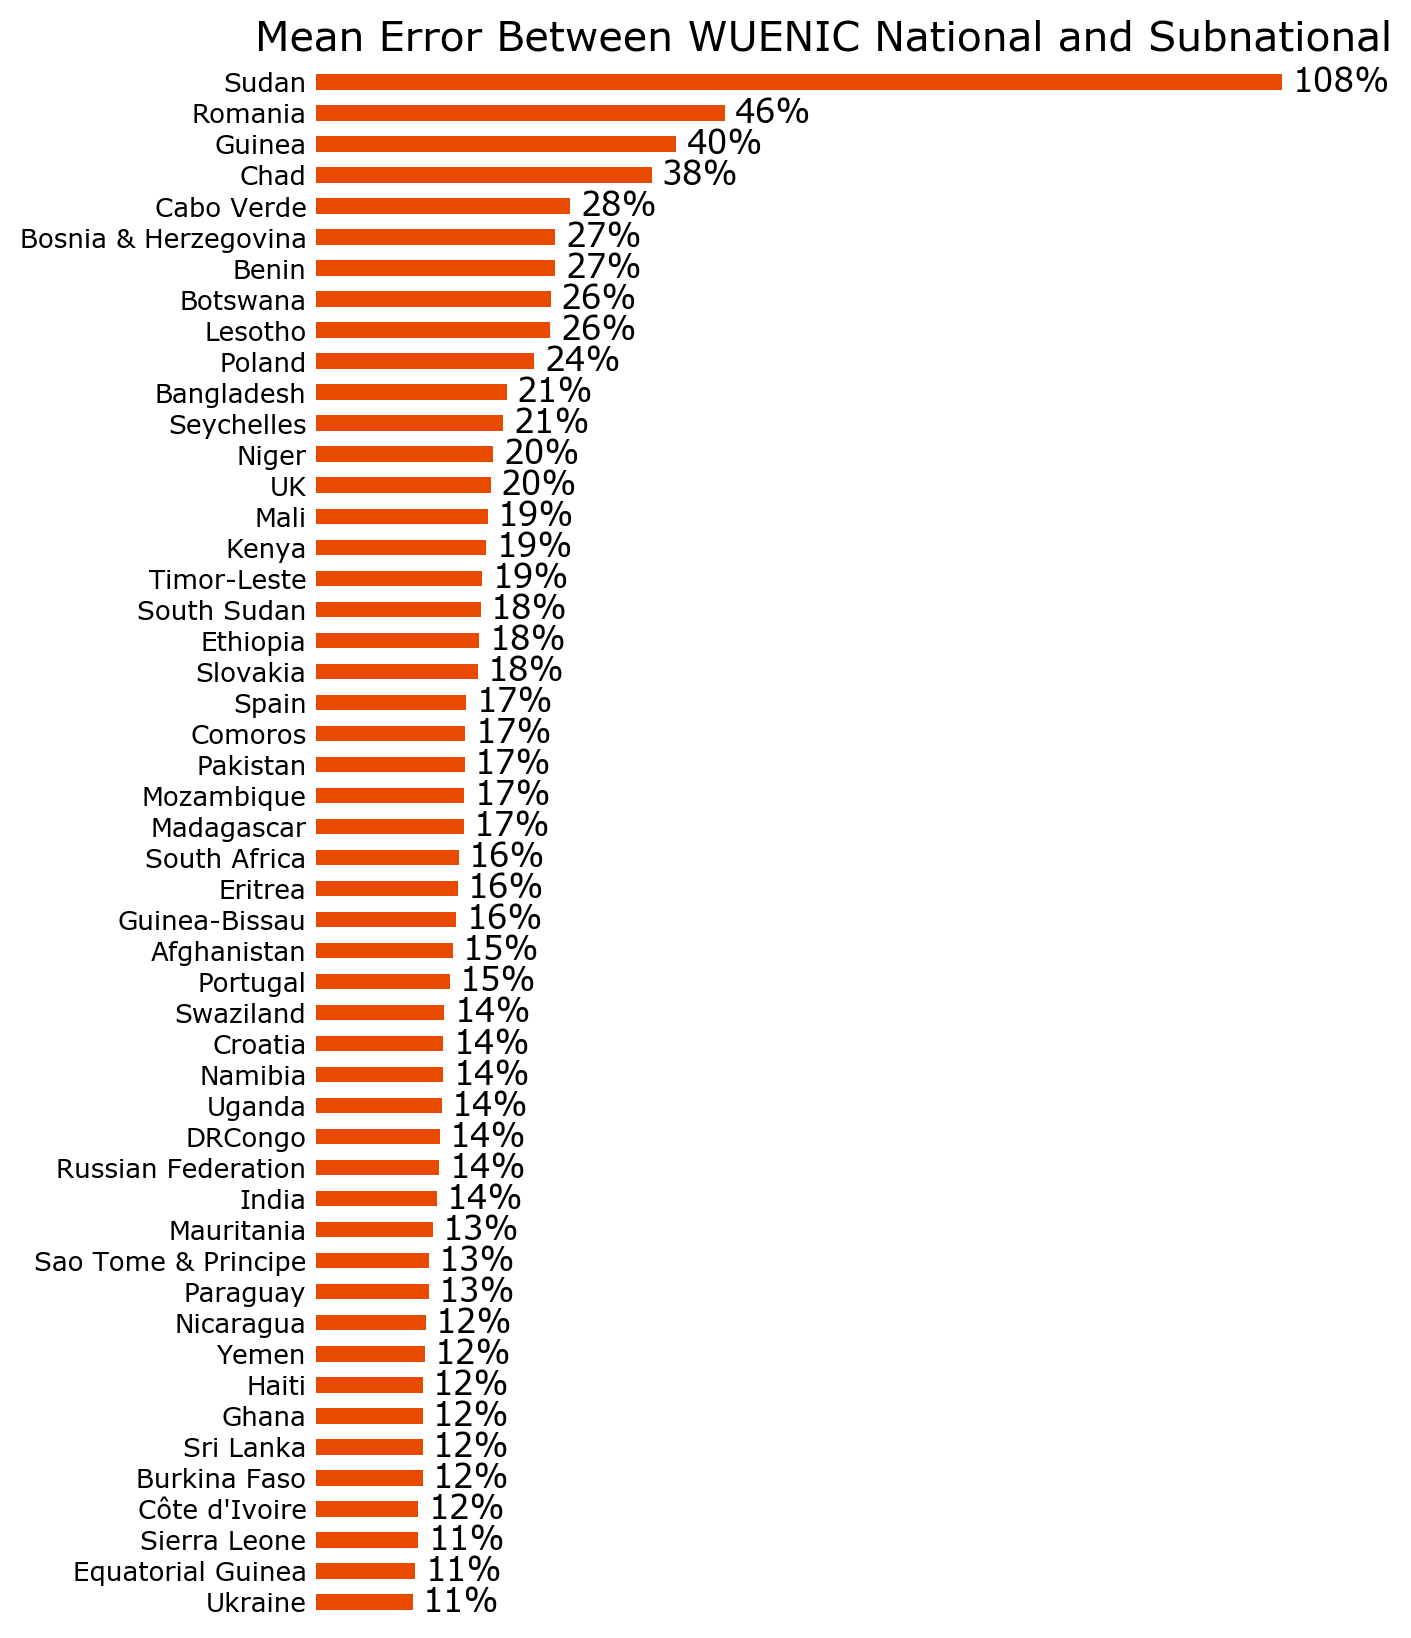

In [13]:
to_plot = aligned_data.groupby('ISO_code').difference.mean().sort_values(ascending=False)
to_plot.rename(index=code_to_name, inplace=True)

PLOT_LIM = 50
FS=12

with styled_fig_ax(size='tallest', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot.divide(100).head(PLOT_LIM).sort_values(),
                font_size=FS,
                horizontal=True,
                label_formatter=pct_func_formatter(),
                color=PALETTE['orange']
               )
    
    
    ax.set_ylabel('')
    ax.set_title('Mean Error Between WUENIC National and Subnational'.format(PLOT_LIM))

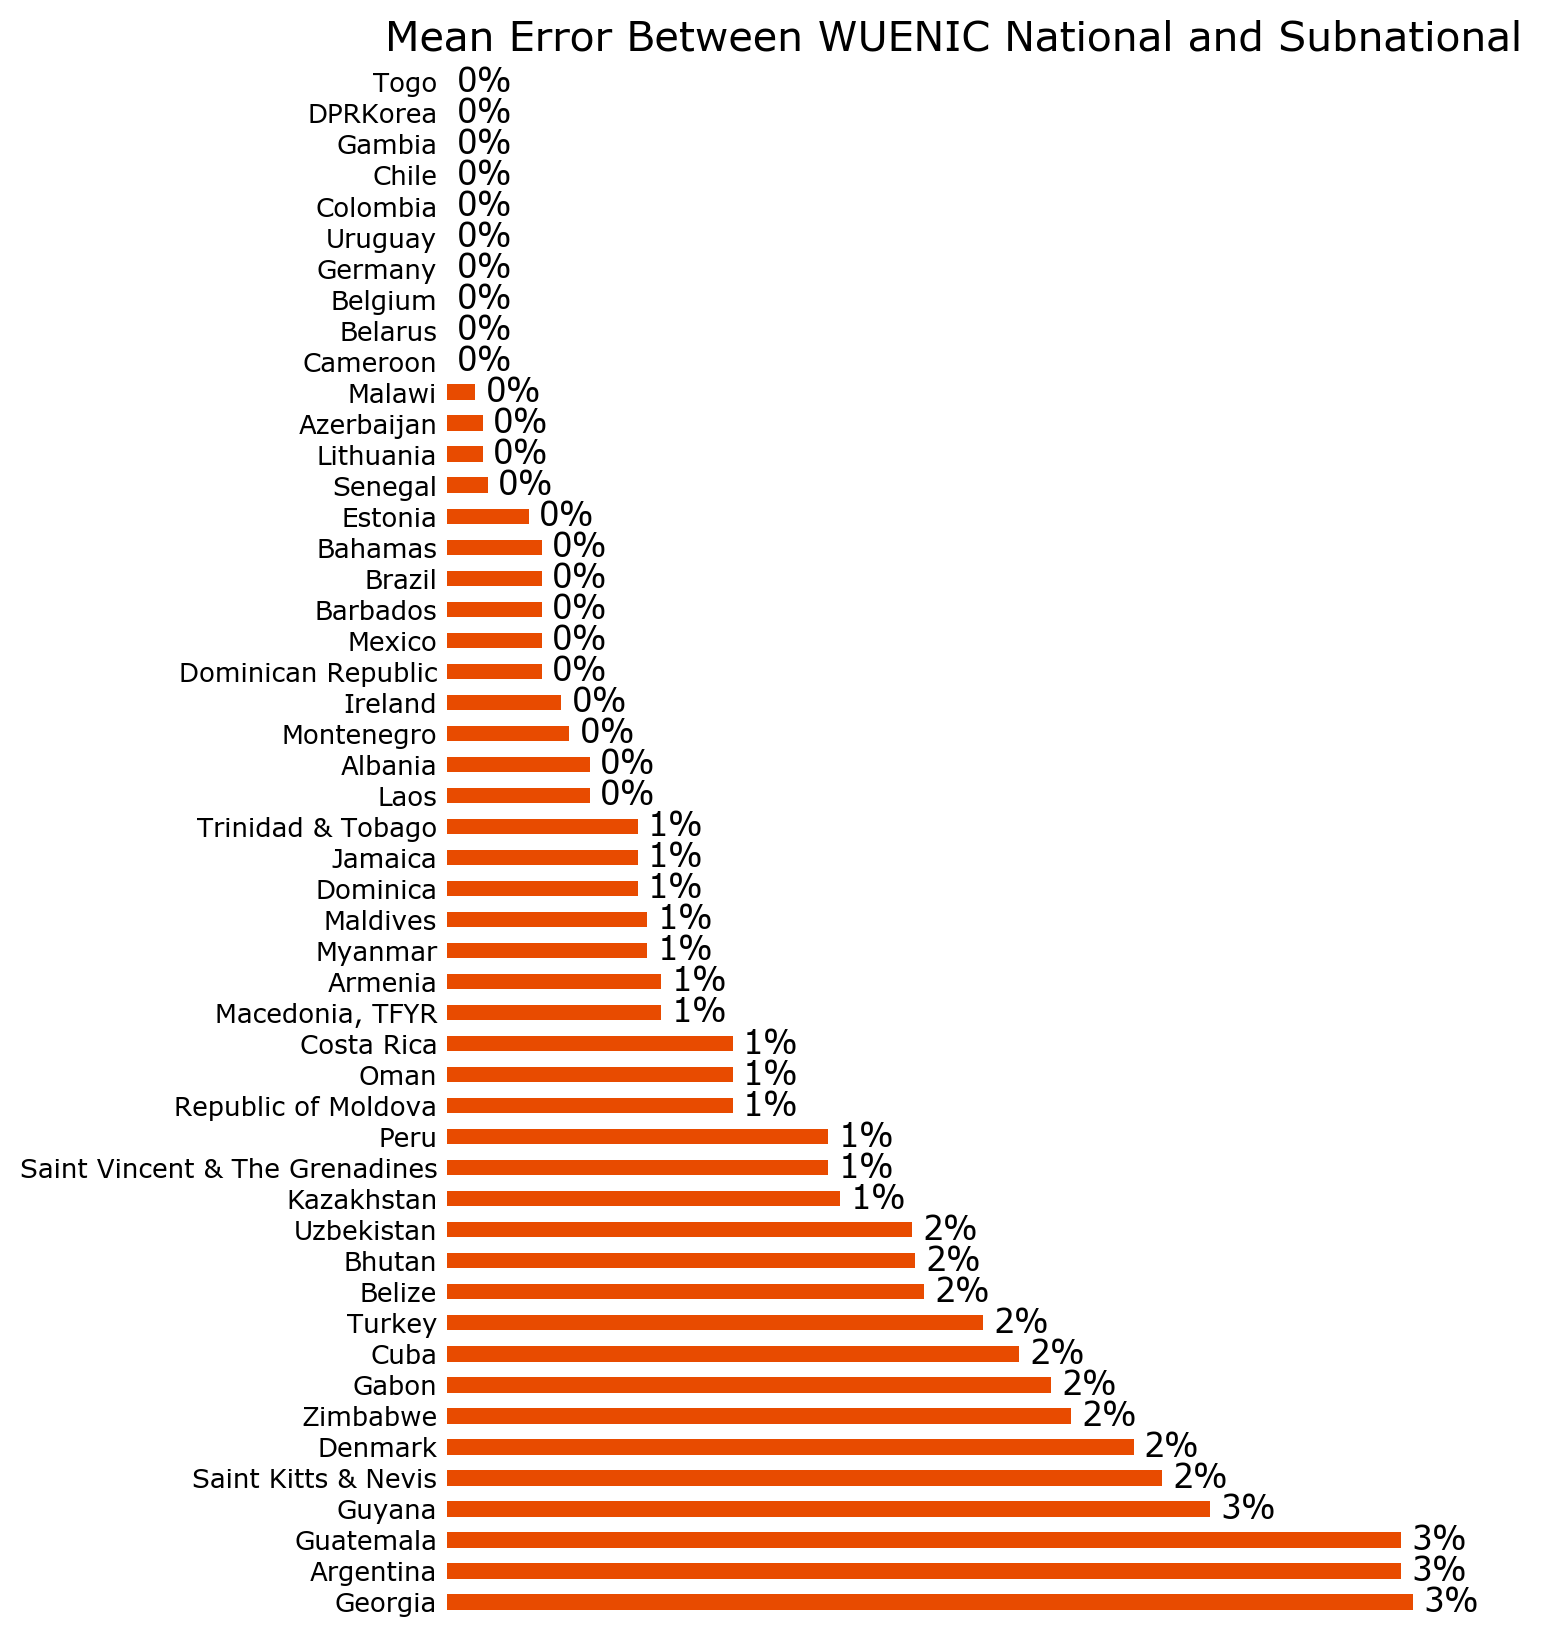

In [35]:
mean_error = aligned_data.groupby('ISO_code').difference.mean().sort_values(ascending=True)
to_plot = mean_error
to_plot.rename(index=code_to_name, inplace=True)

PLOT_LIM = 50
FS=12

with styled_fig_ax(size='tallest', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot.divide(100).head(PLOT_LIM).sort_values(ascending=False),
                font_size=FS,
                horizontal=True,
                label_formatter=pct_func_formatter(),
                color=PALETTE['orange']
               )
    
    
    ax.set_ylabel('')
    ax.set_title('Mean Error Between WUENIC National and Subnational'.format(PLOT_LIM))

In [49]:
no_outliers.difference.clip_upper(100).value_counts()

100.0    951
Name: difference, dtype: int64

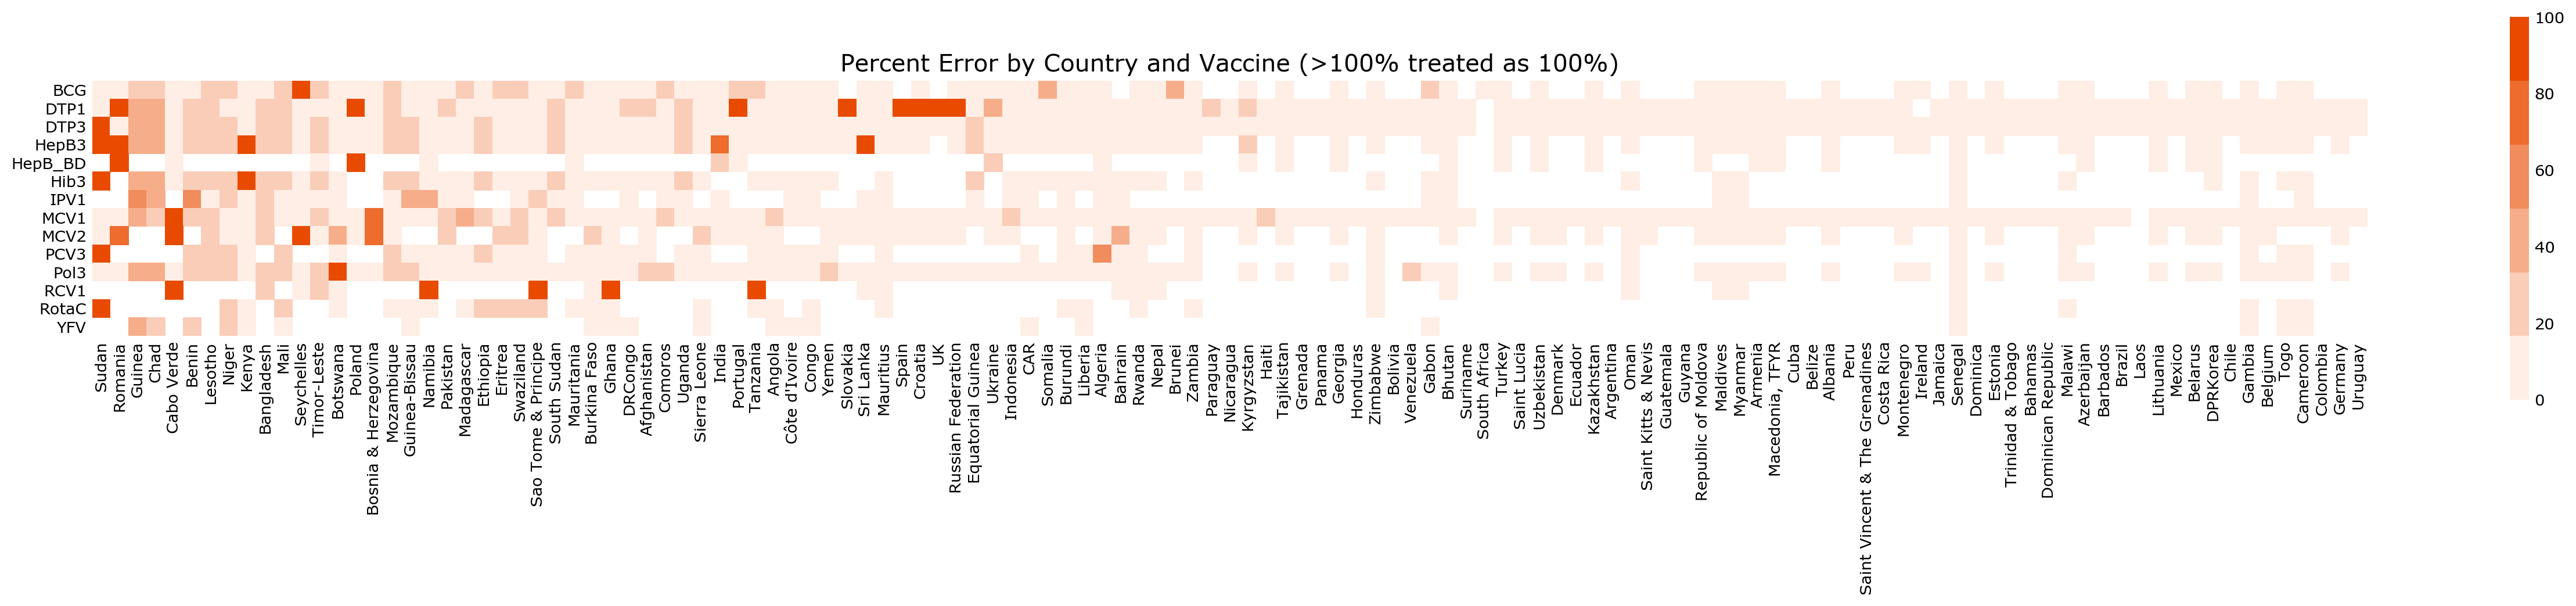

In [73]:
no_outliers = aligned_data.copy() #[aligned_data.difference < 100]
no_outliers.difference = no_outliers.difference.clip_upper(100)

to_plot = no_outliers.groupby(['ISO_code', 'Vaccine']).difference.sum().unstack()#.fillna(0)
to_plot.rename(index=code_to_name, inplace=True)

to_plot = to_plot.loc[to_plot.sum(axis=1).sort_values(ascending=False).index]

with styled_fig_ax(size='custom', other_rc_params={'figure.figsize': (26, 5)},
                   font_size=12, zero_lines=False, seaborn=True):
    sns.heatmap(to_plot.T,
                annot=False,
                fmt=',.0f',
                square=True,
                 linewidths=0,
                xticklabels=True,
                cmap=sns.light_palette(PALETTE['orange']),
#                 cbar_kws={"orientation": "horizontal", 'shrink': 0.4},
                cbar=True)
    
    ax = plt.gca()
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    ax.grid(linestyle='-', linewidth='0.0', color='red')
    
    ax.set_title('Percent Error by Country and Vaccine (>100% treated as 100%)')

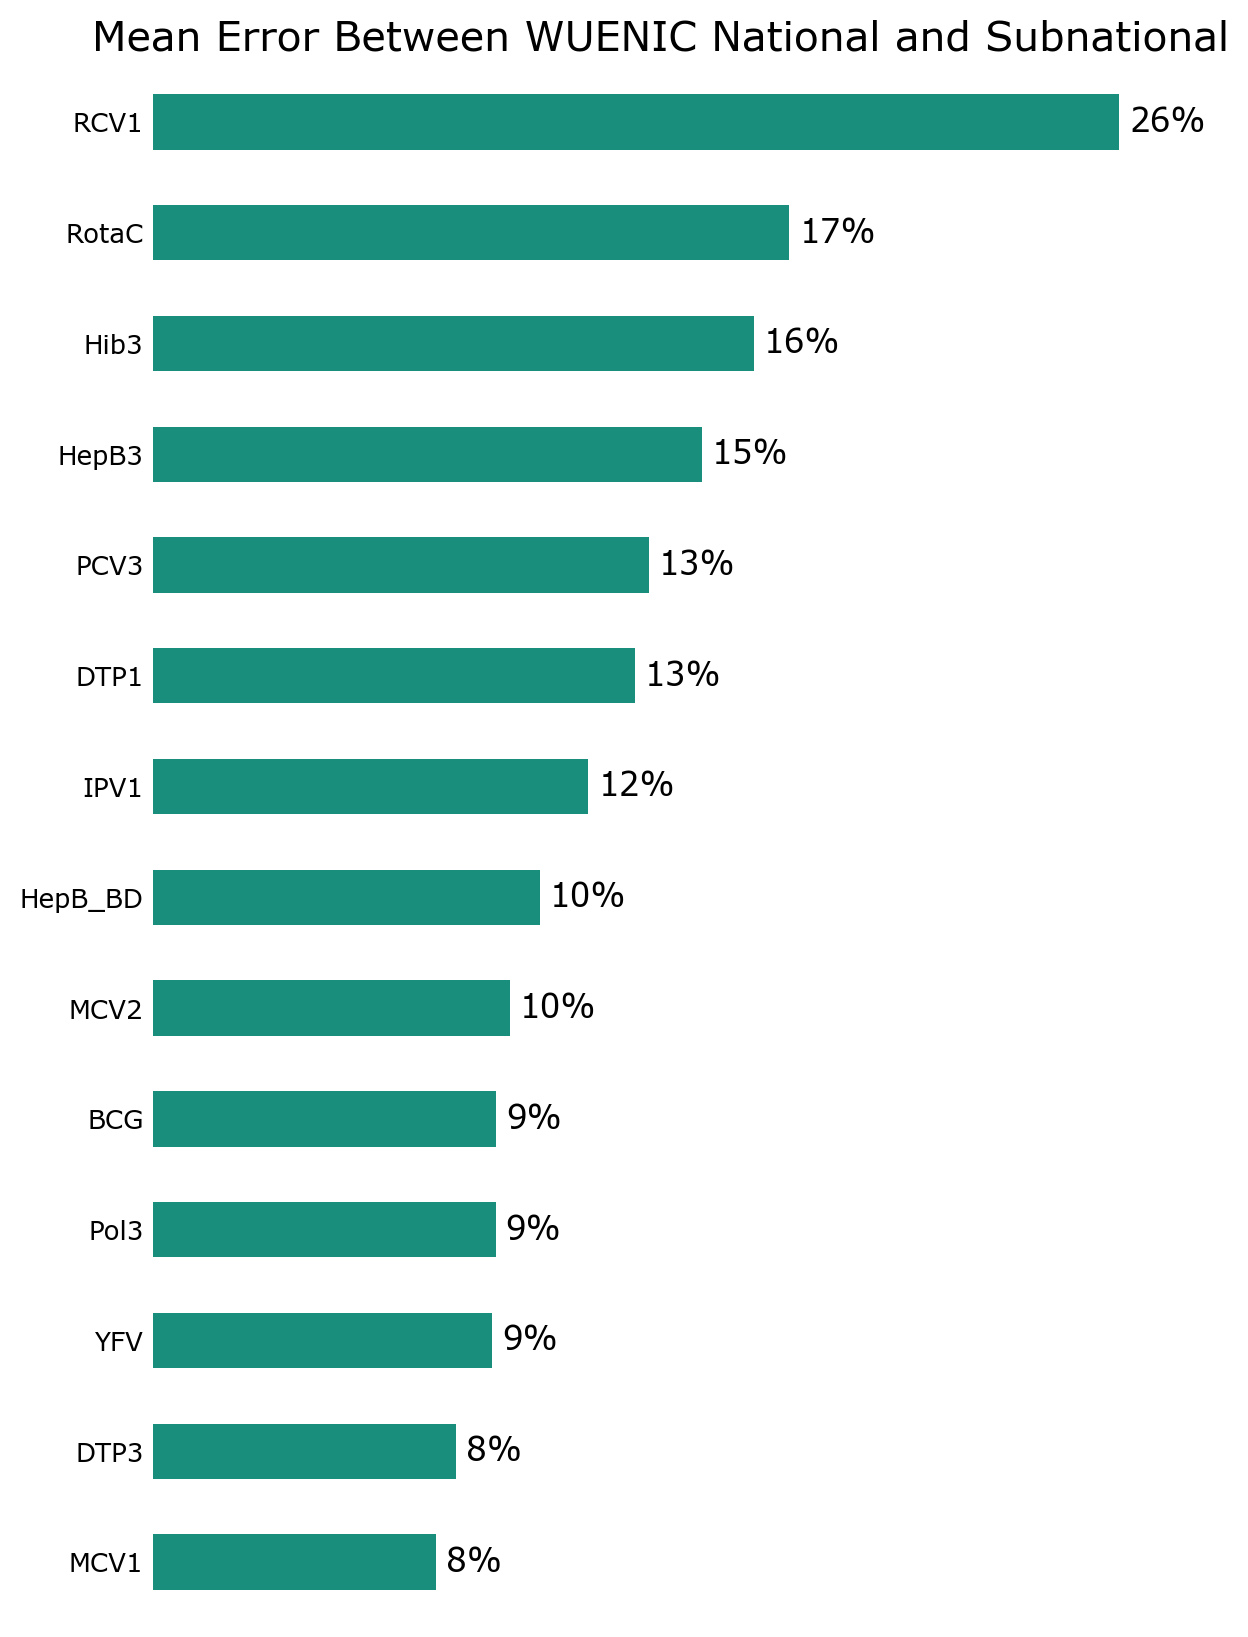

In [14]:
to_plot = aligned_data.groupby('Vaccine').difference.mean().sort_values(ascending=False)
# to_plot.rename(index=code_to_name, inplace=True)

PLOT_LIM = 50
FS=12

with styled_fig_ax(size='tallest', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot.divide(100).head(PLOT_LIM).sort_values(),
                font_size=FS,
                horizontal=True,
                label_formatter=pct_func_formatter(),
                color=PALETTE['green']
               )
    
    
    ax.set_ylabel('')
    ax.set_title('Mean Error Between WUENIC National and Subnational'.format(PLOT_LIM))

In [7]:
aligned_data[aligned_data.ISO_code == 'SDN']

,coverage,ISO_code,Vaccine,2016,difference
913,97.0,SDN,BCG,96.0,1.0
914,100.0,SDN,DTP1,97.0,3.0
915,329.0,SDN,DTP3,93.0,236.0
916,329.0,SDN,HepB3,93.0,236.0
917,329.0,SDN,Hib3,93.0,236.0
918,88.0,SDN,MCV1,86.0,2.0
919,70.0,SDN,MCV2,69.0,1.0
920,195.0,SDN,PCV3,93.0,102.0
921,93.0,SDN,Pol3,93.0,0.0
922,357.0,SDN,RotaC,90.0,267.0
